In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
sns.set(rc = {'figure.figsize':(10, 6)})
pd.set_option("precision", 3)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
folder = "/home/jarobyte/scratch/guemes/icdar/en/baseline/experiments/"

In [3]:
files = os.listdir(folder)
len(files)

24

In [4]:
logs = pd.concat([pd.read_csv(folder + f) 
                       for f in tqdm(os.listdir(folder))])\
.assign(dropout = lambda df: df.dropout.round(2))
print(logs.shape)
logs.head()

  0%|          | 0/24 [00:00<?, ?it/s]

(1160, 21)


,epoch,train_loss,train_error_rate,dev_loss,dev_error_rate,training_minutes,learning_rate,weight_decay,model,max_sequence_length,...,feedforward_dimension,encoder_layers,decoder_layers,attention_heads,activation,dropout,parameters,encoder_tokens,decoder_tokens,experiment_id
0,1,1.249,34.691,1.301,33.839,1.756,1.000e-04,0.0,Transformer,110,...,1024,2,2,8,relu,0.0,3841700,164,164,22716984_6
1,2,0.510,16.547,1.204,31.998,3.531,1.000e-04,0.0,Transformer,110,...,1024,2,2,8,relu,0.0,3841700,164,164,22716984_6
2,3,0.341,12.590,1.189,29.514,5.310,1.000e-04,0.0,Transformer,110,...,1024,2,2,8,relu,0.0,3841700,164,164,22716984_6
3,4,0.201,8.937,1.363,28.663,7.089,1.000e-04,0.0,Transformer,110,...,1024,2,2,8,relu,0.0,3841700,164,164,22716984_6
4,5,0.110,6.278,1.581,27.415,8.864,1.000e-04,0.0,Transformer,110,...,1024,2,2,8,relu,0.0,3841700,164,164,22716984_6


In [5]:
experiments = logs\
.assign(fit = lambda df: df.apply(lambda r: {k:r[k] for k in ["train_loss", 
                                                              "dev_loss", 
                                                              "epoch"]}, 
                                  axis = 1))\
.groupby("experiment_id")\
.agg({"fit":(lambda x: min(x, key = lambda y: y["dev_loss"])),
      "parameters":max, 
      "dropout":max,
      "weight_decay":max,
      "embedding_dimension":max,
      "encoder_layers":max,
      "training_minutes":max})\
.assign(parameters = lambda df: df.parameters / 10**6, 
        train_loss = lambda df: df.fit.map(lambda x: x["train_loss"]),
        dev_loss = lambda df: df.fit.map(lambda x: x["dev_loss"]),
        epoch = lambda df: df.fit.map(lambda x: x["epoch"]))\
.drop(columns = "fit")
experiments.head(10)

,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
experiment_id,,,,,,,,,
22694262_1,3.842,0.3,1.000e-04,256,2,97.559,0.279,0.955,19
22694262_10,3.842,0.3,1.000e-03,256,2,94.565,0.713,1.308,43
22694262_11,3.842,0.5,1.000e-02,256,2,95.309,2.389,2.436,44
22694262_12,3.842,0.1,1.000e-02,256,2,95.523,2.313,2.386,49
22694262_2,3.842,0.4,1.000e-03,256,2,98.653,0.785,1.292,48
22694262_3,3.842,0.4,1.000e-03,256,2,97.496,0.718,1.297,34
22694262_4,3.842,0.2,1.000e-03,256,2,94.670,0.529,1.212,41
22694262_5,3.842,0.5,1.000e-02,256,2,94.663,2.395,2.436,48
22694262_6,3.842,0.5,1.000e-04,256,2,96.813,0.455,1.010,25


# evaluation

In [6]:
evaluation_folder = "/home/jarobyte/scratch/guemes/icdar/en/baseline/evaluation/"

In [7]:
evaluation_files = os.listdir(evaluation_folder)
len(evaluation_files)

24

In [8]:
evaluation = pd.concat([pd.read_csv(evaluation_folder + f) 
                       for f in tqdm(os.listdir(evaluation_folder))])
print(evaluation.shape)
evaluation.head()

  0%|          | 0/24 [00:00<?, ?it/s]

(240, 9)


,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting
0,22694262_4,-2156.334,disjoint,greedy,100,2.274,45.621,1029.354,NaN
1,22694262_4,-1073.759,disjoint,greedy,50,1.125,45.621,535.476,NaN
2,22694262_4,-2171.101,disjoint,beam,100,5.813,45.621,1036.091,NaN
3,22694262_4,-1073.897,disjoint,beam,50,3.931,45.621,535.539,NaN
4,22694262_4,-26.966,sliding,greedy,50,19.911,45.621,57.923,uniform


In [9]:
results = evaluation.merge(experiments, right_index = True, left_on = "experiment_id")\
.sort_values("improvement", ascending = False)
results.head(10)

,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
4,22716984_12,21.073,sliding,greedy,50,21.680,45.621,36.007,uniform,3.842,0.0,0.000e+00,256,2,90.922,0.506,1.202,2
5,22716984_12,20.842,sliding,greedy,50,21.792,45.621,36.112,triangle,3.842,0.0,0.000e+00,256,2,90.922,0.506,1.202,2
6,22716984_12,20.771,sliding,greedy,50,21.658,45.621,36.145,bell,3.842,0.0,0.000e+00,256,2,90.922,0.506,1.202,2
1,22716984_12,16.573,disjoint,greedy,50,1.337,45.621,38.060,NaN,3.842,0.0,0.000e+00,256,2,90.922,0.506,1.202,2
0,22716984_12,9.222,disjoint,greedy,100,2.726,45.621,41.413,NaN,3.842,0.0,0.000e+00,256,2,90.922,0.506,1.202,2
7,22694262_6,1.884,sliding,beam,50,160.486,45.621,44.761,uniform,3.842,0.5,1.000e-04,256,2,96.813,0.455,1.010,25
9,22694262_6,1.758,sliding,beam,50,160.681,45.621,44.818,bell,3.842,0.5,1.000e-04,256,2,96.813,0.455,1.010,25
8,22694262_6,1.758,sliding,beam,50,161.417,45.621,44.818,triangle,3.842,0.5,1.000e-04,256,2,96.813,0.455,1.010,25
4,22694262_1,1.466,sliding,greedy,50,19.887,45.621,44.952,uniform,3.842,0.3,1.000e-04,256,2,97.559,0.279,0.955,19
6,22716984_11,1.286,sliding,greedy,50,20.036,45.621,45.034,bell,3.842,0.0,0.000e+00,256,2,89.366,0.499,1.197,2


<AxesSubplot:>

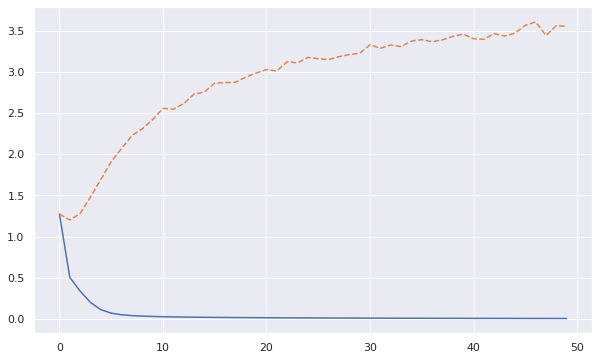

In [10]:
logs.query("experiment_id == '22716984_12'").train_loss.plot()
logs.query("experiment_id == '22716984_12'").dev_loss.plot(ls = "--")

In [11]:
results.query("experiment_id == '22716984_12'")\
[["experiment_id", "window", "window_size", "decoding", "weighting", "improvement"]]\
.sort_values(["window", "window_size", "decoding", "weighting"])\
.pivot(index = "experiment_id", 
       values = "improvement", 
       columns = ["window", "window_size", "decoding", "weighting"])

window        disjoint                        sliding                   \
window_size        50              100            50                     
decoding          beam  greedy    beam greedy    beam                    
weighting          NaN     NaN     NaN    NaN    bell triangle uniform   
experiment_id                                                            
22716984_12    -10.099  16.573 -26.329  9.222  -5.795   -5.753  -5.373   

window                                  
window_size                             
decoding       greedy                   
weighting        bell triangle uniform  
experiment_id                           
22716984_12    20.771   20.842  21.073